### TFT PIPELINE

In [1]:
import torch
import numpy as np
from datetime import datetime
import os
from  lightning.pytorch import Trainer
from  lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from  lightning.pytorch.loggers import TensorBoardLogger
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.data.dataModule.tft.dataModule import CareerDataModule
from backend.ml_pipe.models.tft.model import TFTModel
from  lightning.pytorch.loggers import CSVLogger
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, TemporalFusionTransformer, QuantileLoss


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from backend.ml_pipe.data.database.mongodb import MongoDb
import pandas as pd
import matplotlib.pyplot as plt

def load_and_filter_labels_from_mongodb(
    user="florianrunkel",
    password="ur04mathesis",
    db_name="Database",
    collection="timeseries_dataset",
    top_n_remove=5,
    show_plot=True
):
    # 1. Daten laden
    mongo_client = MongoDb(user=user, password=password, db_name=db_name)
    result = mongo_client.get_all(collection)
    raw_data = result.get('data', [])
    df = pd.DataFrame(raw_data)

    # 2. Label bereinigen
    df["label"] = pd.to_numeric(df["label"], errors="coerce")
    df = df[df["label"].notna()]
    df = df[df["label"] > 0]

    # 3. Häufigste Labels identifizieren
    top_labels = df["label"].value_counts().nlargest(5).index.tolist()
    print("Häufigste Labels (werden gefiltert):", top_labels)

    # 5. Plot (optional)
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(df["label"], bins=50)
        plt.title("Verteilung der Labels (gefiltert)")
        plt.xlabel("label (Tage)")
        plt.ylabel("Anzahl")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 6. Zusammenfassung
    print(f"Datensätze nach Filterung: {len(df)}")
    print(f"Minimales Label: {df['label'].min()}")
    print(f"Maximales Label: {df['label'].max()}")
    print(f"Durchschnittliches Label: {df['label'].mean():.2f}")

    return df

In [3]:
from lightning.pytorch.callbacks import Callback

class PrintLossCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("train_loss")
        if loss is not None:
            print(f"Train Loss (Epoch {trainer.current_epoch}): {loss:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("val_loss")
        if loss is not None:
            print(f"Val Loss (Epoch {trainer.current_epoch}): {loss:.4f}")


Starte Karriere-Vorhersage Pipeline...
Lade Daten aus MongoDB...
Häufigste Labels (werden gefiltert): [46, 16, 92, 31, 183]


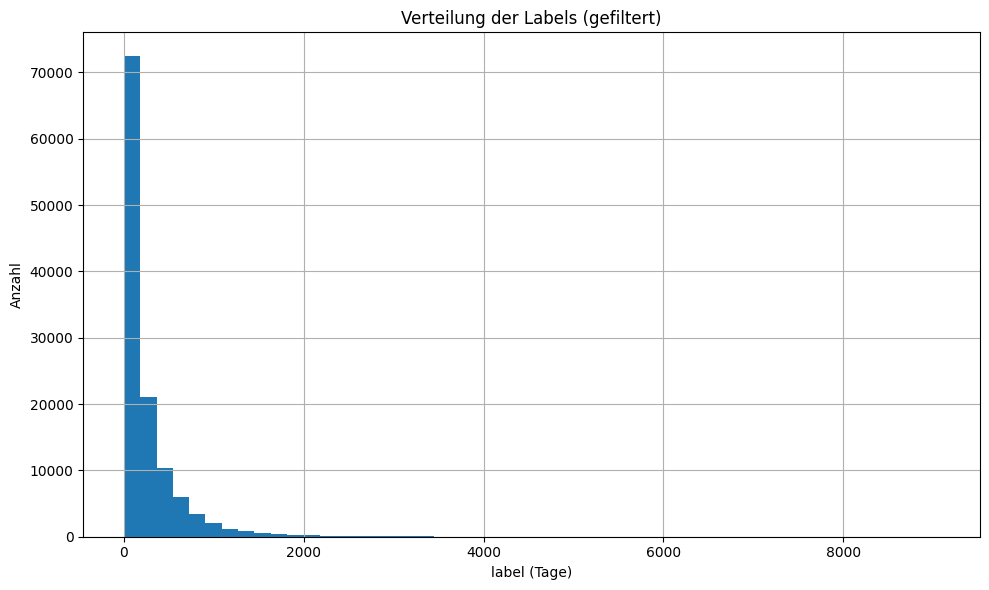

Datensätze nach Filterung: 119552
Minimales Label: 3
Maximales Label: 9065
Durchschnittliches Label: 264.80
DataFrame Shape: (119552, 17)
DataFrame Columns: ['_id', 'profile_id', 'aktuelle_position', 'zeitpunkt', 'label', 'berufserfahrung_bis_zeitpunkt', 'anzahl_wechsel_bisher', 'anzahl_jobs_bisher', 'durchschnittsdauer_bisheriger_jobs', 'highest_degree', 'age_category', 'anzahl_standortwechsel', 'study_field', 'company_name', 'company_industry', 'company_location', 'company_size_category']
Erste Zeile:
_id                                    683f04c78b7b61a57df733d0
profile_id                            zorikto-ochirov-63547a143
aktuelle_position                            Software Developer
zeitpunkt                                          1640300400.0
label                                                      1257
berufserfahrung_bis_zeitpunkt                              2337
anzahl_wechsel_bisher                                         3
anzahl_jobs_bisher                         

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 282 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__profile_id': 12}, {'__group_id__profile_id': 15}, {'__group_id__profile_id': 17}, {'__group_id__profile_id': 20}, {'__group_id__profile_id': 25}, {'__group_id__profile_id': 28}, {'__group_id__profile_id': 31}, {'__group_id__profile_id': 32}, {'__group_id__profile_id': 55}, {'__group_id__profile_id': 59}]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 2867 unknown classes which were set to NaN
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Training: 81466 Kandidaten
Validation: 38086 Kandidaten

DEBUG - Training Daten:
   profile_id  time_idx  target         position  feature_0  feature_1  \
0           0         0   168.0  Working Student      981.0        1.0   
1           0         1   168.0  Working Student     1019.0        1.0   
2           0         2   168.0  Working Student     1057.0        1.0   
3           0         3   168.0  Working Student     1080.0        1.0   
4           0         4   168.0           Intern     1157.0        2.0   

   feature_2  feature_3  feature_4  feature_5  ...  feature_16  feature_17  \
0        2.0      700.0        3.0        2.0  ...         0.0         0.0   
1        2.0      700.0        3.0        2.0  ...         1.0        17.0   
2        2.0      700.0        3.0        2.0  ...         1.0        17.0   
3        2.0      700.0        3.0        2.0  ...         1.0        17.0   
4        3.0      426.5        3.0        2.0  ...         1.0        17.0   

   fe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 505.0k
Starte Training...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 380 K  | train
3  | prescalers                         | ModuleDic

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 1337/1337 [01:56<00:00, 11.47it/s, v_num=17, train_loss_step=11.10, val_loss=26.60, train_loss_epoch=13.90]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1337/1337 [01:57<00:00, 11.34it/s, v_num=17, train_loss_step=11.10, val_loss=26.60, train_loss_epoch=13.90]
Bestes Modell: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints/tft-best-epoch=19-val_loss=26.59.ckpt


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Modell-Evaluation auf Validierungsdaten:
MAE: 49.68 Tage
RMSE: 80.36 Tage
Speichere Modell...
Modell gespeichert unter: ./saved_models/tft_20250627_113734.ckpt


In [4]:
import torch
from datetime import datetime
from  lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from  lightning.pytorch.loggers import TensorBoardLogger
import  lightning.pytorch as pl
import os
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import MAE, RMSE

def run_pipeline():
    print("Starte Karriere-Vorhersage Pipeline...")

    # 1. Daten laden
    print("Lade Daten aus MongoDB...")
    df = load_and_filter_labels_from_mongodb()
    
    # Debug: Zeige DataFrame-Info
    print(f"DataFrame Shape: {df.shape}")
    print(f"DataFrame Columns: {df.columns.tolist()}")
    print(f"Erste Zeile:")
    print(df.iloc[0])

    datamodule = CareerDataModule(df)
    datamodule.setup()
    print(f"Training: {len(datamodule.training)} Kandidaten")
    print(f"Validation: {len(datamodule.validation)} Kandidaten")
    
    # Debug: Zeige Training-Daten
    print("\nDEBUG - Training Daten:")
    print(datamodule.training.head())
    print(f"Feature-Spalten: {[col for col in datamodule.training.columns if col.startswith('feature_')]}")
    
    # Debug: Prüfe Feature-Werte
    feature_cols = [col for col in datamodule.training.columns if col.startswith('feature_')]
    if feature_cols:
        print(f"\nDEBUG - Feature-Statistiken:")
        for col in feature_cols[:5]:  # Erste 5 Features
            print(f"{col}: min={datamodule.training[col].min()}, max={datamodule.training[col].max()}, mean={datamodule.training[col].mean():.2f}")
    
    # Debug: Prüfe ob alle Features 0 sind
    all_features_zero = True
    for col in feature_cols:
        if datamodule.training[col].sum() > 0:
            all_features_zero = False
            break
    
    if all_features_zero:
        print("\nWARNUNG: Alle Features sind 0! Das ist ein Problem!")
        return None, None
    else:
        print("\nFeatures sind nicht alle 0 - das ist gut!")
    
    # 3. Modell initialisieren
    print("Initialisiere TFT Modell...")
    model = TemporalFusionTransformer.from_dataset(
        datamodule.training_dataset,
        learning_rate=0.01,
        hidden_size=32,
        attention_head_size=4,  # Etwas mehr Fokus pro Head
        dropout=0.1,
        hidden_continuous_size=16,
        output_size=7,  # Für p10, p20 ... p90
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

    lr_logger = LearningRateMonitor()

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="tft-best-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        mode="min",
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min"
    )

    logger = TensorBoardLogger(save_dir="logs")

    trainer = Trainer(
        max_epochs=20,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        gradient_clip_val=0.1,
        log_every_n_steps=10,
        enable_checkpointing=True,
        callbacks=[lr_logger, checkpoint_callback, early_stopping, PrintLossCallback()],
        logger=logger,
        deterministic=True,  # ✅ Für Reproduzierbarkeit
    )

    # 5. Training starten
    print("Starte Training...")
    trainer.fit(
        model,
        train_dataloaders=datamodule.train_dataloader(),
        val_dataloaders=datamodule.val_dataloader(),
    )

    # 6. Bestes Modell laden
    best_model_path = checkpoint_callback.best_model_path
    print(f"Bestes Modell: {best_model_path}")

    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # Evaluation auf Validierungsdaten
    val_dataloader = datamodule.val_dataloader()
    
    # Vorhersagen und tatsächliche Werte sammeln
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)
    #print(predictions)

    # Alle Tensoren auf dasselbe Gerät bringen
    actuals = actuals.to(predictions.device)

    # Metriken initialisieren
    from pytorch_forecasting.metrics import MAE, RMSE
    mae_metric = MAE().to(predictions.device)
    rmse_metric = RMSE().to(predictions.device)

    # Metriken berechnen
    mae = mae_metric(predictions, actuals)
    rmse = rmse_metric(predictions, actuals)

    print("\nModell-Evaluation auf Validierungsdaten:")
    print(f"MAE: {mae:.2f} Tage")
    print(f"RMSE: {rmse:.2f} Tage")
    
    print("Speichere Modell...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"./saved_models/tft_{timestamp}.ckpt"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    trainer.save_checkpoint(model_path)
    print(f"Modell gespeichert unter: {model_path}")
    return best_model, trainer

# Pipeline ausführen
best_model, trainer = run_pipeline()
#[I 2025-05-20 16:25:48,382] Trial 0 finished with value: 137.7418975830078 and parameters: {'gradient_clip_val': 0.7663094383604092, 'hidden_size': 63, 'dropout': 0.27868811302673885, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.011199776102729224}. Best is trial 0 with value: 137.7418975830078.


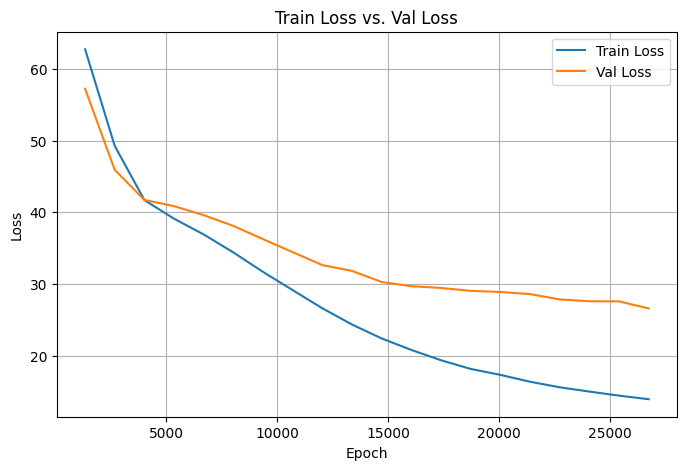

In [5]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# EventAccumulator initialisieren und laden
ea = event_accumulator.EventAccumulator(trainer.logger.log_dir)
ea.Reload()

# Die richtigen Keys für die Losses
val_loss = ea.Scalars('val_loss')
train_loss = ea.Scalars('train_loss_epoch')

# Plot
plt.figure(figsize=(8,5))
plt.plot([x.step for x in train_loss], [x.value for x in train_loss], label='Train Loss')
plt.plot([x.step for x in val_loss], [x.value for x in val_loss], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Val Loss')
plt.legend()
plt.grid(True)
plt.show()

Starte Karriere-Vorhersage Pipeline...
Lade Daten aus MongoDB...
Häufigste Labels (werden gefiltert): [46, 16, 92, 31, 183]


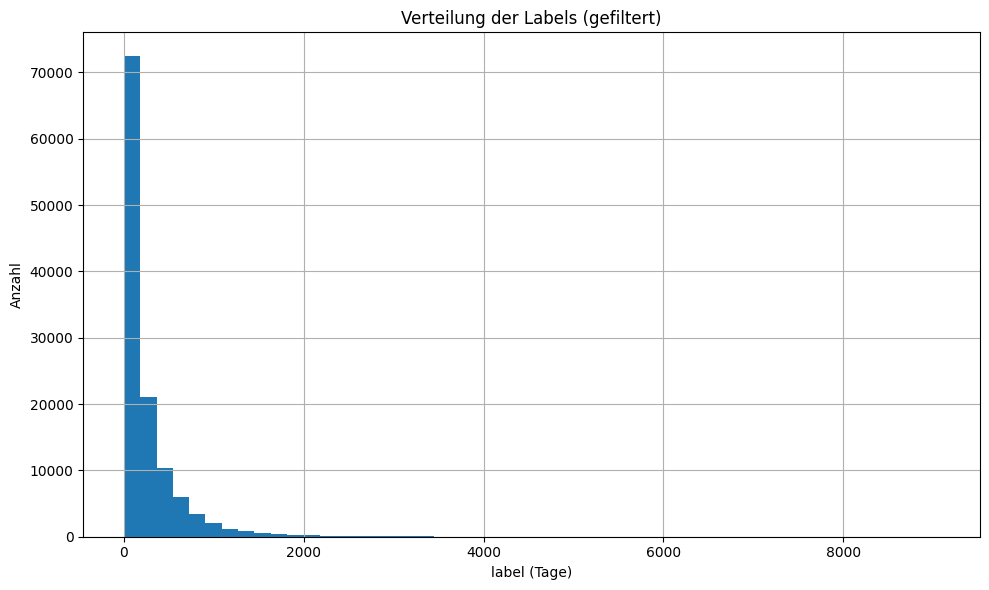

Datensätze nach Filterung: 119552
Minimales Label: 3
Maximales Label: 9065
Durchschnittliches Label: 264.80
DataFrame Shape: (119552, 17)
DataFrame Columns: ['_id', 'profile_id', 'aktuelle_position', 'zeitpunkt', 'label', 'berufserfahrung_bis_zeitpunkt', 'anzahl_wechsel_bisher', 'anzahl_jobs_bisher', 'durchschnittsdauer_bisheriger_jobs', 'highest_degree', 'age_category', 'anzahl_standortwechsel', 'study_field', 'company_name', 'company_industry', 'company_location', 'company_size_category']
Erste Zeile:
_id                                    683f04c78b7b61a57df733d0
profile_id                            zorikto-ochirov-63547a143
aktuelle_position                            Software Developer
zeitpunkt                                          1640300400.0
label                                                      1257
berufserfahrung_bis_zeitpunkt                              2337
anzahl_wechsel_bisher                                         3
anzahl_jobs_bisher                         

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 282 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__profile_id': 12}, {'__group_id__profile_id': 15}, {'__group_id__profile_id': 17}, {'__group_id__profile_id': 20}, {'__group_id__profile_id': 25}, {'__group_id__profile_id': 28}, {'__group_id__profile_id': 31}, {'__group_id__profile_id': 32}, {'__group_id__profile_id': 55}, {'__group_id__profile_id': 59}]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 2867 unknown classes which were set to NaN
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Training: 81466 Kandidaten
Validation: 38086 Kandidaten

DEBUG - Training Daten:
   profile_id  time_idx  target         position  feature_0  feature_1  \
0           0         0   168.0  Working Student      981.0        1.0   
1           0         1   168.0  Working Student     1019.0        1.0   
2           0         2   168.0  Working Student     1057.0        1.0   
3           0         3   168.0  Working Student     1080.0        1.0   
4           0         4   168.0           Intern     1157.0        2.0   

   feature_2  feature_3  feature_4  feature_5  ...  feature_16  feature_17  \
0        2.0      700.0        3.0        2.0  ...         0.0         0.0   
1        2.0      700.0        3.0        2.0  ...         1.0        17.0   
2        2.0      700.0        3.0        2.0  ...         1.0        17.0   
3        2.0      700.0        3.0        2.0  ...         1.0        17.0   
4        3.0      426.5        3.0        2.0  ...         1.0        17.0   

   fe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 505.0k
Starte Training...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 380 K  | train
3  | prescalers                         | ModuleDic

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 1337/1337 [01:56<00:00, 11.47it/s, v_num=17, train_loss_step=11.10, val_loss=26.60, train_loss_epoch=13.90]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1337/1337 [01:57<00:00, 11.34it/s, v_num=17, train_loss_step=11.10, val_loss=26.60, train_loss_epoch=13.90]
Bestes Modell: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints/tft-best-epoch=19-val_loss=26.59.ckpt


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Modell-Evaluation auf Validierungsdaten:
MAE: 49.68 Tage
RMSE: 80.36 Tage
Speichere Modell...
Modell gespeichert unter: ./saved_models/tft_20250627_113734.ckpt


In [ ]:
import torch
from datetime import datetime
from  lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from  lightning.pytorch.loggers import TensorBoardLogger
import  lightning.pytorch as pl
import os
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import MAE, RMSE

def run_pipeline():
    print("Starte Karriere-Vorhersage Pipeline...")

    # 1. Daten laden
    print("Lade Daten aus MongoDB...")
    df = load_and_filter_labels_from_mongodb()
    
    # Debug: Zeige DataFrame-Info
    print(f"DataFrame Shape: {df.shape}")
    print(f"DataFrame Columns: {df.columns.tolist()}")
    print(f"Erste Zeile:")
    print(df.iloc[0])

    datamodule = CareerDataModule(df)
    datamodule.setup()
    print(f"Training: {len(datamodule.training)} Kandidaten")
    print(f"Validation: {len(datamodule.validation)} Kandidaten")
    
    # Debug: Zeige Training-Daten
    print("\nDEBUG - Training Daten:")
    print(datamodule.training.head())
    print(f"Feature-Spalten: {[col for col in datamodule.training.columns if col.startswith('feature_')]}")
    
    # Debug: Prüfe Feature-Werte
    feature_cols = [col for col in datamodule.training.columns if col.startswith('feature_')]
    if feature_cols:
        print(f"\nDEBUG - Feature-Statistiken:")
        for col in feature_cols[:5]:  # Erste 5 Features
            print(f"{col}: min={datamodule.training[col].min()}, max={datamodule.training[col].max()}, mean={datamodule.training[col].mean():.2f}")
    
    # Debug: Prüfe ob alle Features 0 sind
    all_features_zero = True
    for col in feature_cols:
        if datamodule.training[col].sum() > 0:
            all_features_zero = False
            break
    
    if all_features_zero:
        print("\nWARNUNG: Alle Features sind 0! Das ist ein Problem!")
        return None, None
    else:
        print("\nFeatures sind nicht alle 0 - das ist gut!")
    
    # 3. Modell initialisieren
    print("Initialisiere TFT Modell...")
    model = TemporalFusionTransformer.from_dataset(
        datamodule.training_dataset,
        learning_rate=0.01,
        hidden_size=32,
        attention_head_size=4,  # Etwas mehr Fokus pro Head
        dropout=0.1,
        hidden_continuous_size=16,
        output_size=7,  # Für p10, p20 ... p90
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

    lr_logger = LearningRateMonitor()

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="tft-best-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        mode="min",
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min"
    )

    logger = TensorBoardLogger(save_dir="logs")

    trainer = Trainer(
        max_epochs=50,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        gradient_clip_val=0.1,
        log_every_n_steps=10,
        enable_checkpointing=True,
        callbacks=[lr_logger, checkpoint_callback, early_stopping, PrintLossCallback()],
        logger=logger,
        deterministic=True,  # ✅ Für Reproduzierbarkeit
    )

    # 5. Training starten
    print("Starte Training...")
    trainer.fit(
        model,
        train_dataloaders=datamodule.train_dataloader(),
        val_dataloaders=datamodule.val_dataloader(),
    )

    # 6. Bestes Modell laden
    best_model_path = checkpoint_callback.best_model_path
    print(f"Bestes Modell: {best_model_path}")

    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # Evaluation auf Validierungsdaten
    val_dataloader = datamodule.val_dataloader()
    
    # Vorhersagen und tatsächliche Werte sammeln
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)
    #print(predictions)

    # Alle Tensoren auf dasselbe Gerät bringen
    actuals = actuals.to(predictions.device)

    # Metriken initialisieren
    from pytorch_forecasting.metrics import MAE, RMSE
    mae_metric = MAE().to(predictions.device)
    rmse_metric = RMSE().to(predictions.device)

    # Metriken berechnen
    mae = mae_metric(predictions, actuals)
    rmse = rmse_metric(predictions, actuals)

    print("\nModell-Evaluation auf Validierungsdaten:")
    print(f"MAE: {mae:.2f} Tage")
    print(f"RMSE: {rmse:.2f} Tage")
    
    print("Speichere Modell...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"./saved_models/tft_{timestamp}.ckpt"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    trainer.save_checkpoint(model_path)
    print(f"Modell gespeichert unter: {model_path}")
    return best_model, trainer

# Pipeline ausführen
best_model, trainer = run_pipeline()
#[I 2025-05-20 16:25:48,382] Trial 0 finished with value: 137.7418975830078 and parameters: {'gradient_clip_val': 0.7663094383604092, 'hidden_size': 63, 'dropout': 0.27868811302673885, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.011199776102729224}. Best is trial 0 with value: 137.7418975830078.


hp_metric
lr-Adam
train_loss_step
epoch
val_loss
val_SMAPE
val_MAE
val_RMSE
val_MAPE
train_loss_epoch


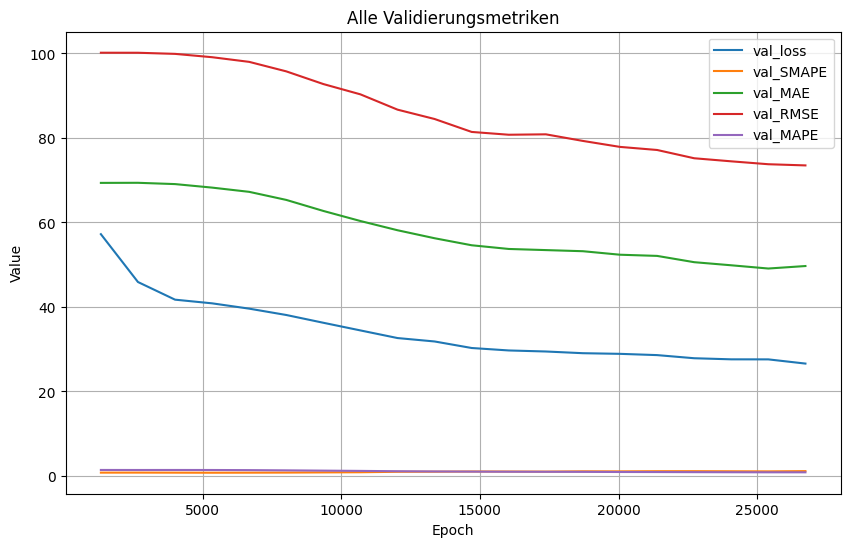

In [6]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(trainer.logger.log_dir)
ea.Reload()

for key in ea.Tags()['scalars']:
    print(key)

val_keys = [k for k in ea.Tags()['scalars'] if k.startswith('val_')]
plt.figure(figsize=(10,6))
for key in val_keys:
    values = ea.Scalars(key)
    plt.plot([x.step for x in values], [x.value for x in values], label=key)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Alle Validierungsmetriken')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import json
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

linkedin_data = {"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}

from backend.ml_pipe.models.tft.predict import predict
prediction = predict(linkedin_data)
print(prediction)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extrahierte Features: 4 Zeilen
Maximale Sequenzlänge: 4
Anzahl Profile: 1

DEBUG - Erste Dokumente:
Dokument 0:
  profile_id: new_user
  aktuelle_position: Senior Team Lead
  berufserfahrung_bis_zeitpunkt: 0.0
  anzahl_wechsel_bisher: 0
  zeitpunkt: 1443650400.0
  label: 762.0
Dokument 1:
  profile_id: new_user
  aktuelle_position: Sales Consultant
  berufserfahrung_bis_zeitpunkt: 762.0
  anzahl_wechsel_bisher: 1
  zeitpunkt: 1509490800.0
  label: 1703.0
Dokument 2:
  profile_id: new_user
  aktuelle_position: Sales Development Representative
  berufserfahrung_bis_zeitpunkt: 2465.0
  anzahl_wechsel_bisher: 2
  zeitpunkt: 1659304800.0
  label: 122.0

DEBUG - Profile new_user:
  Anzahl Einträge: 4
  Erste Einträge:
    Eintrag 0: position=Senior Team Lead, zeitpunkt=1443650400.0
    Eintrag 1: position=Sales Consultant, zeitpunkt=1509490800.0
    Eintrag 2: position=Sales Development Representative, zeitpunkt=1659304800.0
  Echte Positionen: 4
    {'position': 'Senior Team Lead', 'branche

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mache Vorhersage...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Raw prediction: [[[256.66925048828125, 291.6016845703125, 391.10662841796875, 662.5902709960938, 856.17626953125, 877.3331298828125, 923.9623413085938], [262.07904052734375, 294.242431640625, 391.644775390625, 661.5968017578125, 853.1163330078125, 873.5308837890625, 918.1077270507812]], [[223.31689453125, 266.74310302734375, 379.6053466796875, 680.516357421875, 880.4446411132812, 904.5545043945312, 954.302001953125], [221.51678466796875, 264.21051025390625, 378.7731628417969, 682.70703125, 883.9843139648438, 908.1951904296875, 957.2071533203125]], [[571.6716918945312, 581.549560546875, 617.33251953125, 689.648681640625, 749.19873046875, 760.8639526367188, 777.364990234375], [568.03564453125, 582.738525390625, 622.9140625, 705.89404296875, 763.2650756835938, 774.8975219726562, 790.2877197265625]], [[778.8505859375, 801.1036376953125, 805.2787475585938, 808.854736328125, 811.9421997070312, 815.6524047851562, 828.7052001953125], [nan, nan, nan, nan, nan, nan, nan]], [[254.69134521484375, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:121: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([1, 2, 4, 4]). Returning list instead of torch.Tensor.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:121: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([1, 2, 4, 2]). Returning list instead of torch.Tensor.
  warnings.warn(
